In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
import glob
from torchvision import models
import numpy as np
from PIL import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings("ignore", message="The parameter 'pretrained' is deprecated")
warnings.filterwarnings("ignore", message="Arguments other than a weight enum or `None` for 'weights' are deprecated")

================ Model Achitecture ================

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Using pretrained VGG16 features
        vgg16 = models.vgg16(pretrained=True)

        self.features = nn.Sequential(
            vgg16.features[0:10],  # Output shape: [batch, 128, 56, 56]
        )

        # Additional convolutional layers
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # Output: [batch, 256, 56, 56]
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),  # Output: [batch, 128, 56, 56]
            nn.ReLU(),
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),  # Output: [batch, 64, 56, 56]
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),  # Output: [batch, 64, 56, 56]
            nn.ReLU()
        )

        # Fully connected layers for regression
        self.regressor = nn.Sequential(
            nn.Linear(64 * 56 * 56, 4096),  # Input flattened from [batch, 64, 56, 56], Output: [batch, 4096]
            nn.LeakyReLU(negative_slope=0.01),
            nn.LayerNorm(4096), 
            nn.Dropout(p=0.3),
            nn.Linear(4096, 2048),  # Output: [batch, 2048]
            nn.LeakyReLU(negative_slope=0.01),
            nn.LayerNorm(2048),  
            nn.Dropout(p=0.3),
            nn.Linear(2048, 1024),  # Output: [batch, 1024]
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(1024, 1)      # Final output shape: [batch, 1]
        )

    def forward(self, x):
        # Forward pass through VGG16 feature layers
        x = self.features(x)
        

        # Forward pass through conv_1 layers
        x1 = self.conv_1(x)
        

        # Forward pass through conv_2 layers
        x2 = self.conv_2(x1)
       
        
        # Skip connection
        skip = self.conv_3(x)
    

        # Add skip connection
        x = x2 + skip
       

        # Flatten the feature map for regressor input
        x = torch.flatten(x, 1)
       

        # Pass through the regressor network
        x = self.regressor(x)
       
        
        return x

# Instantiate and move to device
custom_model = CustomCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = custom_model.to(device)

# Test the model with a sample input
sample_input = torch.randn(4, 3, 224, 224).to(device)  # Input size (4 batches, 3 channels, 224x224)
output = model(sample_input)
print("Output:", output)  # Expected shape: [4, 1]


In [3]:
for param in model.features.parameters():
    param.requires_grad = False

In [4]:
model

CustomCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (conv_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()


============= Data Preprocessing ===============

In [2]:
'''mean is 0, and standard deviation varies randomly between 0.01 and 0.20'''

def add_noise(image_np, sigma):
    noisy_image = image_np + np.random.randn(*image_np.shape) * sigma
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image.astype(np.float32)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image) 
    
     
        image_np = image.permute(1, 2, 0).numpy()  # Convert the tensor to a NumPy array

        sigma = np.random.uniform(0.01, 0.20) # Random sigma value

        # Add noise to the image
        noisy_image_np = add_noise(image_np, sigma)

        # Convert the noisy image back to a PyTorch tensor
        noisy_image = torch.tensor(noisy_image_np).permute(2, 0, 1)  # Back to (C, H, W)
    
        return noisy_image.float(), sigma



In [8]:
sigma = np.random.uniform(0.01, 0.20, 5)
print(sigma)

[0.12397574 0.04496946 0.19742528 0.15132421 0.18784845]


In [9]:
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Directory where your images are stored
image_dir = 'D:/Dr. Jarez Miah_Don\'t delete/Noise estimation/Div2k_Flickr2k_OST/flickr30k_images'

# List all images in the directory
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle the list to randomize the image order
random.shuffle(images)

# Perform 70-30 split
train_images, val_images = train_test_split(images, test_size=0.3, random_state=42)

# Create datasets
train_dataset = CustomDataset(image_paths=train_images, transform=transform)
val_dataset = CustomDataset(image_paths=val_images, transform=transform)

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

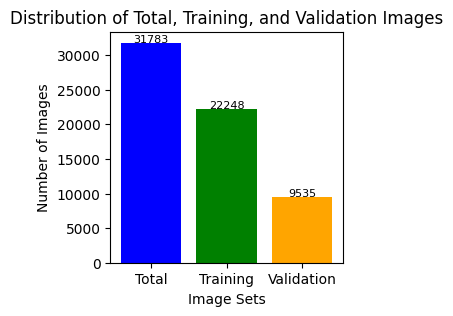

In [10]:

# Check the split sizes
total_images = len(images)
training_images = len(train_images)
validation_images = len(val_images)

# Labels for the bars
labels = ['Total', 'Training', 'Validation']

# Data for the bars
image_counts = [total_images, training_images, validation_images]

# Create the bar chart
plt.figure(figsize=(3,3))
plt.bar(labels, image_counts, color=['blue', 'green', 'orange'])

# Add titles and labels
plt.title('Distribution of Total, Training, and Validation Images')
plt.xlabel('Image Sets')
plt.ylabel('Number of Images')

# Show the values on top of each bar
for i, count in enumerate(image_counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=8)

# Display the plot
plt.show()



In [11]:
for X,y in valloader:
    print(X.max(), X.min())
    print(X.shape)
    print(y.shape)
    break

tensor(1.) tensor(0.)
torch.Size([16, 3, 224, 224])
torch.Size([16])


In [12]:
for X,y in valloader:
    print(y)
    break
    

tensor([0.0929, 0.1996, 0.1866, 0.1171, 0.1939, 0.1864, 0.0197, 0.1443, 0.0209,
        0.1101, 0.1621, 0.1483, 0.0315, 0.0412, 0.0141, 0.1019],
       dtype=torch.float64)


============ Training and Validation =============

In [13]:
from tqdm import tqdm 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    """ Calculate MAPE as a custom function since sklearn does not have a built-in function for it. """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train(model, dataloader, loss_fn, optimizer, epoch, device):
    model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []

    for batch_idx, (data, target) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch} (Training)')):
        data, target = data.to(device), target.to(device).float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output.squeeze(), target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        
        running_loss += loss.item()

        # Collect predictions and targets for metric calculation
        all_preds.extend(output.squeeze().detach().cpu().numpy())  # Detach the tensor here
        all_targets.extend(target.cpu().numpy())

    avg_loss = running_loss / len(dataloader)

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    mape = mean_absolute_percentage_error(all_targets, all_preds)
    rmse = mean_squared_error(all_targets, all_preds, squared=False)  # Calculate RMSE
  

    print(f'Epoch [{epoch}], Train Loss (MSE): {avg_loss:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}')

 


In [14]:
import torch
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """ Calculate MAPE as a custom function since sklearn does not have a built-in function for it. """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def test(model, dataloader, loss_fn, epoch, device):
    model.eval() 
    running_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad(): 
        for data, target in tqdm(dataloader, desc=f'Epoch {epoch} (Testing)'):
            data, target = data.to(device), target.to(device).float()

            output = model(data)

            loss = loss_fn(output.squeeze(), target)

            running_loss += loss.item()
            all_preds.extend(output.squeeze().cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = running_loss / len(dataloader)

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    rmse = mean_squared_error(all_targets, all_preds, squared=False)  # RMSE
    r2 = r2_score(all_targets, all_preds)
    mape = mean_absolute_percentage_error(all_targets, all_preds)
    
 

    # Print the first 5 true and predicted sigmas
    print(f"True sigmas: {all_targets[:5]}")
    print(f"Model predicted sigmas: {all_preds[:5]}")

    
    print(f'Epoch [{epoch}], Test Loss (MSE): {avg_loss:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}')
 


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.MSELoss()
#writer = SummaryWriter()
epochs = 25
for epoch in range(1, epochs + 1):
    train(model, trainloader, loss_fn, optimizer, epoch,  device)
    test(model, valloader, loss_fn, epoch, device)
    scheduler.step()
torch.save(model.state_dict(), f'test12.pth')


Epoch 1 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:07<00:00,  2.86it/s]


Epoch [1], Train Loss (MSE): 0.0099, MAE: 0.0402, R2: -2.3094, MAPE: 64.7072, RMSE: 0.0995, RMSLE: nan


Epoch 1 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:29<00:00,  3.98it/s]


True sigmas: [0.07975943, 0.185491, 0.1320668, 0.07988848, 0.079581656]
Model predicted sigmas: [0.07193882, 0.17150405, 0.12322824, 0.06631886, 0.053919915]
Epoch [1], Test Loss (MSE): 0.0003, MAE: 0.0152, R2: 0.8900, MAPE: 29.5104, RMSE: 0.0181, RMSLE: nan


Epoch 2 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:11<00:00,  2.83it/s]


Epoch [2], Train Loss (MSE): 0.0004, MAE: 0.0156, R2: 0.8686, MAPE: 24.7228, RMSE: 0.0199, RMSLE: nan


Epoch 2 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:28<00:00,  4.02it/s]


True sigmas: [0.05209347, 0.083706565, 0.09303743, 0.16190286, 0.19173764]
Model predicted sigmas: [0.035747223, 0.055423267, 0.06831351, 0.16813496, 0.17999233]
Epoch [2], Test Loss (MSE): 0.0004, MAE: 0.0164, R2: 0.8821, MAPE: 30.3220, RMSE: 0.0188, RMSLE: nan


Epoch 3 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:09<00:00,  2.84it/s]


Epoch [3], Train Loss (MSE): 0.0002, MAE: 0.0112, R2: 0.9337, MAPE: 17.8414, RMSE: 0.0141, RMSLE: nan


Epoch 3 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:28<00:00,  4.02it/s]


True sigmas: [0.045953434, 0.041215558, 0.16351224, 0.029209495, 0.10733362]
Model predicted sigmas: [0.060756285, 0.044925675, 0.15678738, 0.043376137, 0.11229604]
Epoch [3], Test Loss (MSE): 0.0001, MAE: 0.0079, R2: 0.9676, MAPE: 18.3315, RMSE: 0.0099, RMSLE: 0.0092


Epoch 4 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:23<00:00,  2.76it/s]


Epoch [4], Train Loss (MSE): 0.0002, MAE: 0.0097, R2: 0.9500, MAPE: 15.1700, RMSE: 0.0123, RMSLE: nan


Epoch 4 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:28<00:00,  4.02it/s]


True sigmas: [0.059121534, 0.13974436, 0.13766372, 0.17511065, 0.06193969]
Model predicted sigmas: [0.052436963, 0.12577969, 0.12661089, 0.18142962, 0.04851865]
Epoch [4], Test Loss (MSE): 0.0001, MAE: 0.0097, R2: 0.9561, MAPE: 15.3399, RMSE: 0.0114, RMSLE: nan


Epoch 5 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:09<00:00,  2.84it/s]


Epoch [5], Train Loss (MSE): 0.0001, MAE: 0.0088, R2: 0.9591, MAPE: 13.5104, RMSE: 0.0112, RMSLE: nan


Epoch 5 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:33<00:00,  3.87it/s]


True sigmas: [0.17168511, 0.01413931, 0.10000056, 0.033332888, 0.123672634]
Model predicted sigmas: [0.17822558, 0.030045625, 0.09973269, 0.045979723, 0.12827778]
Epoch [5], Test Loss (MSE): 0.0001, MAE: 0.0074, R2: 0.9722, MAPE: 17.4276, RMSE: 0.0092, RMSLE: 0.0086


Epoch 6 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:18<00:00,  2.79it/s]


Epoch [6], Train Loss (MSE): 0.0001, MAE: 0.0059, R2: 0.9805, MAPE: 8.9091, RMSE: 0.0076, RMSLE: nan


Epoch 6 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:34<00:00,  3.85it/s]


True sigmas: [0.035499137, 0.09961351, 0.100925215, 0.18271717, 0.046709955]
Model predicted sigmas: [0.036864527, 0.09371505, 0.09871439, 0.1895506, 0.047712073]
Epoch [6], Test Loss (MSE): 0.0000, MAE: 0.0044, R2: 0.9886, MAPE: 6.5996, RMSE: 0.0059, RMSLE: 0.0052


Epoch 7 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:26<00:00,  2.75it/s]


Epoch [7], Train Loss (MSE): 0.0001, MAE: 0.0059, R2: 0.9804, MAPE: 8.8950, RMSE: 0.0077, RMSLE: 0.0069


Epoch 7 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:43<00:00,  3.64it/s]


True sigmas: [0.14456347, 0.014650094, 0.047882117, 0.032871146, 0.17275313]
Model predicted sigmas: [0.15202451, 0.01308656, 0.039831586, 0.033474043, 0.18768668]
Epoch [7], Test Loss (MSE): 0.0000, MAE: 0.0050, R2: 0.9857, MAPE: 6.6963, RMSE: 0.0066, RMSLE: 0.0058


Epoch 8 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:33<00:00,  2.71it/s]


Epoch [8], Train Loss (MSE): 0.0001, MAE: 0.0061, R2: 0.9793, MAPE: 9.0029, RMSE: 0.0078, RMSLE: 0.0070


Epoch 8 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:34<00:00,  3.85it/s]


True sigmas: [0.09118709, 0.07027519, 0.09937897, 0.069294795, 0.08339246]
Model predicted sigmas: [0.0987992, 0.06641966, 0.09917763, 0.078284994, 0.08988868]
Epoch [8], Test Loss (MSE): 0.0000, MAE: 0.0052, R2: 0.9855, MAPE: 6.9339, RMSE: 0.0066, RMSLE: 0.0059


Epoch 9 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:13<00:00,  2.82it/s]


Epoch [9], Train Loss (MSE): 0.0001, MAE: 0.0061, R2: 0.9796, MAPE: 9.1982, RMSE: 0.0079, RMSLE: 0.0071


Epoch 9 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:27<00:00,  4.04it/s]


True sigmas: [0.17905207, 0.078318775, 0.18593699, 0.0143157495, 0.1381957]
Model predicted sigmas: [0.18962131, 0.08013781, 0.19042298, 0.022232506, 0.14793478]
Epoch [9], Test Loss (MSE): 0.0001, MAE: 0.0068, R2: 0.9780, MAPE: 10.9193, RMSE: 0.0081, RMSLE: 0.0073


Epoch 10 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:07<00:00,  2.85it/s]


Epoch [10], Train Loss (MSE): 0.0001, MAE: 0.0061, R2: 0.9797, MAPE: 8.9662, RMSE: 0.0078, RMSLE: 0.0070


Epoch 10 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:27<00:00,  4.05it/s]


True sigmas: [0.19585456, 0.030880734, 0.19065773, 0.16434541, 0.09319425]
Model predicted sigmas: [0.18873952, 0.020359464, 0.18417342, 0.17300856, 0.08989186]
Epoch [10], Test Loss (MSE): 0.0001, MAE: 0.0057, R2: 0.9829, MAPE: 8.3505, RMSE: 0.0072, RMSLE: 0.0065


Epoch 11 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:07<00:00,  2.85it/s]


Epoch [11], Train Loss (MSE): 0.0000, MAE: 0.0049, R2: 0.9861, MAPE: 7.3317, RMSE: 0.0065, RMSLE: 0.0058


Epoch 11 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:26<00:00,  4.06it/s]


True sigmas: [0.04987971, 0.1674396, 0.06518747, 0.08499826, 0.19902894]
Model predicted sigmas: [0.050035577, 0.15957043, 0.061023965, 0.08941158, 0.19546208]
Epoch [11], Test Loss (MSE): 0.0000, MAE: 0.0042, R2: 0.9891, MAPE: 5.9124, RMSE: 0.0057, RMSLE: 0.0051


Epoch 12 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:06<00:00,  2.86it/s]


Epoch [12], Train Loss (MSE): 0.0000, MAE: 0.0048, R2: 0.9864, MAPE: 6.9849, RMSE: 0.0063, RMSLE: 0.0057


Epoch 12 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:27<00:00,  4.05it/s]


True sigmas: [0.10887131, 0.18157846, 0.10203183, 0.04740593, 0.07004667]
Model predicted sigmas: [0.10899541, 0.17404601, 0.09591222, 0.05081062, 0.07125728]
Epoch [12], Test Loss (MSE): 0.0000, MAE: 0.0041, R2: 0.9893, MAPE: 5.7454, RMSE: 0.0057, RMSLE: 0.0051


Epoch 13 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:08<00:00,  2.85it/s]


Epoch [13], Train Loss (MSE): 0.0000, MAE: 0.0047, R2: 0.9870, MAPE: 6.8784, RMSE: 0.0063, RMSLE: 0.0056


Epoch 13 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:29<00:00,  3.99it/s]


True sigmas: [0.15419392, 0.06503171, 0.17874463, 0.14317437, 0.17041229]
Model predicted sigmas: [0.16380532, 0.061258834, 0.17615795, 0.15230753, 0.17996876]
Epoch [13], Test Loss (MSE): 0.0000, MAE: 0.0039, R2: 0.9902, MAPE: 5.5978, RMSE: 0.0054, RMSLE: 0.0048


Epoch 14 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:12<00:00,  2.83it/s]


Epoch [14], Train Loss (MSE): 0.0000, MAE: 0.0046, R2: 0.9874, MAPE: 6.6598, RMSE: 0.0061, RMSLE: 0.0055


Epoch 14 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:30<00:00,  3.95it/s]


True sigmas: [0.09529315, 0.13352852, 0.019555023, 0.077812694, 0.039525893]
Model predicted sigmas: [0.09684156, 0.12224034, 0.013720711, 0.08015045, 0.037139155]
Epoch [14], Test Loss (MSE): 0.0000, MAE: 0.0041, R2: 0.9897, MAPE: 5.7678, RMSE: 0.0055, RMSLE: 0.0049


Epoch 15 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:10<00:00,  2.84it/s]


Epoch [15], Train Loss (MSE): 0.0000, MAE: 0.0046, R2: 0.9879, MAPE: 6.5279, RMSE: 0.0060, RMSLE: 0.0054


Epoch 15 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:30<00:00,  3.97it/s]


True sigmas: [0.028931571, 0.04946424, 0.087828085, 0.09063819, 0.09390826]
Model predicted sigmas: [0.029858386, 0.046146803, 0.08240642, 0.093876764, 0.094517685]
Epoch [15], Test Loss (MSE): 0.0000, MAE: 0.0040, R2: 0.9900, MAPE: 5.3998, RMSE: 0.0055, RMSLE: 0.0049


Epoch 16 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:16<00:00,  2.80it/s]


Epoch [16], Train Loss (MSE): 0.0000, MAE: 0.0043, R2: 0.9892, MAPE: 6.2181, RMSE: 0.0057, RMSLE: 0.0051


Epoch 16 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:29<00:00,  3.98it/s]


True sigmas: [0.17475086, 0.18856846, 0.066474736, 0.1375156, 0.19463558]
Model predicted sigmas: [0.18614149, 0.18062845, 0.062901385, 0.14445578, 0.19539575]
Epoch [16], Test Loss (MSE): 0.0000, MAE: 0.0039, R2: 0.9908, MAPE: 5.3535, RMSE: 0.0053, RMSLE: 0.0047


Epoch 17 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:10<00:00,  2.84it/s]


Epoch [17], Train Loss (MSE): 0.0000, MAE: 0.0042, R2: 0.9894, MAPE: 6.0662, RMSE: 0.0056, RMSLE: 0.0050


Epoch 17 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:29<00:00,  3.99it/s]


True sigmas: [0.06429111, 0.15477973, 0.06616424, 0.07877003, 0.19000024]
Model predicted sigmas: [0.065018296, 0.1447058, 0.06356949, 0.08334758, 0.19241558]
Epoch [17], Test Loss (MSE): 0.0000, MAE: 0.0038, R2: 0.9908, MAPE: 5.2231, RMSE: 0.0052, RMSLE: 0.0046


Epoch 18 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:11<00:00,  2.83it/s]


Epoch [18], Train Loss (MSE): 0.0000, MAE: 0.0042, R2: 0.9895, MAPE: 5.9563, RMSE: 0.0056, RMSLE: 0.0050


Epoch 18 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:29<00:00,  3.99it/s]


True sigmas: [0.1075783, 0.16016912, 0.17948358, 0.13439168, 0.19581641]
Model predicted sigmas: [0.10971049, 0.15294097, 0.18243788, 0.14031497, 0.19740938]
Epoch [18], Test Loss (MSE): 0.0000, MAE: 0.0038, R2: 0.9906, MAPE: 5.1331, RMSE: 0.0053, RMSLE: 0.0047


Epoch 19 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:11<00:00,  2.83it/s]


Epoch [19], Train Loss (MSE): 0.0000, MAE: 0.0042, R2: 0.9896, MAPE: 6.0401, RMSE: 0.0056, RMSLE: 0.0050


Epoch 19 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:28<00:00,  4.00it/s]


True sigmas: [0.051786877, 0.07360646, 0.12707059, 0.06620795, 0.18021226]
Model predicted sigmas: [0.053350627, 0.069572784, 0.11915213, 0.07133965, 0.18859161]
Epoch [19], Test Loss (MSE): 0.0000, MAE: 0.0039, R2: 0.9908, MAPE: 5.3496, RMSE: 0.0053, RMSLE: 0.0047


Epoch 20 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:10<00:00,  2.83it/s]


Epoch [20], Train Loss (MSE): 0.0000, MAE: 0.0042, R2: 0.9898, MAPE: 5.9519, RMSE: 0.0056, RMSLE: 0.0050


Epoch 20 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:28<00:00,  4.02it/s]


True sigmas: [0.18280175, 0.17369923, 0.14268148, 0.1660634, 0.18040553]
Model predicted sigmas: [0.18930389, 0.16371742, 0.14001463, 0.17514525, 0.18830654]
Epoch [20], Test Loss (MSE): 0.0000, MAE: 0.0038, R2: 0.9909, MAPE: 5.2415, RMSE: 0.0052, RMSLE: 0.0046


Epoch 21 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:11<00:00,  2.83it/s]


Epoch [21], Train Loss (MSE): 0.0000, MAE: 0.0042, R2: 0.9897, MAPE: 5.8594, RMSE: 0.0056, RMSLE: 0.0050


Epoch 21 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:29<00:00,  4.00it/s]


True sigmas: [0.10525851, 0.02091937, 0.14635952, 0.18775374, 0.13695906]
Model predicted sigmas: [0.10828768, 0.015576084, 0.14219199, 0.19602087, 0.14117245]
Epoch [21], Test Loss (MSE): 0.0000, MAE: 0.0039, R2: 0.9906, MAPE: 5.2359, RMSE: 0.0053, RMSLE: 0.0047


Epoch 22 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:11<00:00,  2.83it/s]


Epoch [22], Train Loss (MSE): 0.0000, MAE: 0.0041, R2: 0.9899, MAPE: 5.7823, RMSE: 0.0055, RMSLE: 0.0049


Epoch 22 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:28<00:00,  4.01it/s]


True sigmas: [0.19346465, 0.16601977, 0.13650705, 0.18170905, 0.12723039]
Model predicted sigmas: [0.19824743, 0.15519503, 0.13369444, 0.19307102, 0.1301415]
Epoch [22], Test Loss (MSE): 0.0000, MAE: 0.0038, R2: 0.9910, MAPE: 5.1969, RMSE: 0.0052, RMSLE: 0.0047


Epoch 23 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:12<00:00,  2.83it/s]


Epoch [23], Train Loss (MSE): 0.0000, MAE: 0.0041, R2: 0.9900, MAPE: 5.8136, RMSE: 0.0055, RMSLE: 0.0049


Epoch 23 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:28<00:00,  4.02it/s]


True sigmas: [0.1410276, 0.06471929, 0.09458474, 0.13869031, 0.15069263]
Model predicted sigmas: [0.14373831, 0.06119233, 0.08923024, 0.14218806, 0.15634334]
Epoch [23], Test Loss (MSE): 0.0000, MAE: 0.0039, R2: 0.9908, MAPE: 5.3196, RMSE: 0.0053, RMSLE: 0.0047


Epoch 24 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:52<00:00,  2.61it/s]


Epoch [24], Train Loss (MSE): 0.0000, MAE: 0.0041, R2: 0.9899, MAPE: 5.8145, RMSE: 0.0055, RMSLE: 0.0049


Epoch 24 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [03:48<00:00,  2.61it/s]


True sigmas: [0.18925624, 0.1487482, 0.045817003, 0.1149418, 0.12325606]
Model predicted sigmas: [0.19699772, 0.1388141, 0.041480754, 0.11988415, 0.12576494]
Epoch [24], Test Loss (MSE): 0.0000, MAE: 0.0039, R2: 0.9906, MAPE: 5.2314, RMSE: 0.0053, RMSLE: 0.0048


Epoch 25 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [10:41<00:00,  2.17it/s]


Epoch [25], Train Loss (MSE): 0.0000, MAE: 0.0041, R2: 0.9899, MAPE: 5.8320, RMSE: 0.0055, RMSLE: 0.0049


Epoch 25 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:29<00:00,  3.99it/s]


True sigmas: [0.11360378, 0.18303688, 0.014642956, 0.011476772, 0.11621418]
Model predicted sigmas: [0.11854194, 0.17361525, 0.012265703, 0.013128053, 0.11850815]
Epoch [25], Test Loss (MSE): 0.0000, MAE: 0.0038, R2: 0.9910, MAPE: 5.2539, RMSE: 0.0052, RMSLE: 0.0047


In [ ]:
#Model run for 50 epochs

In [12]:
#Model run for 50 epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.MSELoss()
writer = SummaryWriter()
epochs = 50
for epoch in range(1, epochs + 1):
    train(model, trainloader, loss_fn, optimizer, epoch, writer, device)
    test(model, valloader, loss_fn, epoch, writer, device)
    scheduler.step()

writer.close()

Epoch 1 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [11:48<00:00,  1.96it/s]


Epoch [1], Train Loss: 0.0104, MAE: 0.0419, R2: -2.4578


Epoch 1 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [04:01<00:00,  2.47it/s]


True sigmas: [0.14946817, 0.01772092, 0.08001985, 0.18250768, 0.14873904]
Model predicted sigmas: [0.12465972, -0.0043164026, 0.0729587, 0.14440379, 0.13720146]
Epoch [1], Test Loss: 0.0005, MAE: 0.0199, R2: 0.8433


Epoch 2 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:46<00:00,  2.64it/s]


Epoch [2], Train Loss: 0.0005, MAE: 0.0169, R2: 0.8481


Epoch 2 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:40<00:00,  3.72it/s]


True sigmas: [0.010389517, 0.13413161, 0.16664267, 0.13205351, 0.13435595]
Model predicted sigmas: [0.0027987435, 0.10342537, 0.14848788, 0.100874245, 0.12174019]
Epoch [2], Test Loss: 0.0005, MAE: 0.0208, R2: 0.8293


Epoch 3 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [3], Train Loss: 0.0002, MAE: 0.0118, R2: 0.9263


Epoch 3 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.75it/s]


True sigmas: [0.057970613, 0.14375506, 0.15459399, 0.029156342, 0.18332009]
Model predicted sigmas: [0.055707067, 0.14415553, 0.17561425, 0.028852744, 0.1953928]
Epoch [3], Test Loss: 0.0001, MAE: 0.0088, R2: 0.9598


Epoch 4 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:36<00:00,  2.69it/s]


Epoch [4], Train Loss: 0.0002, MAE: 0.0102, R2: 0.9441


Epoch 4 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.76it/s]


True sigmas: [0.015549132, 0.1266283, 0.016294263, 0.17881973, 0.16250284]
Model predicted sigmas: [0.017090887, 0.12751205, 0.03587848, 0.16416559, 0.17433113]
Epoch [4], Test Loss: 0.0001, MAE: 0.0062, R2: 0.9796


Epoch 5 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:35<00:00,  2.70it/s]


Epoch [5], Train Loss: 0.0001, MAE: 0.0095, R2: 0.9520


Epoch 5 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:37<00:00,  3.78it/s]


True sigmas: [0.1648362, 0.10640144, 0.1381028, 0.010667434, 0.033662483]
Model predicted sigmas: [0.18543431, 0.116675556, 0.16846386, 0.015671654, 0.04579351]
Epoch [5], Test Loss: 0.0002, MAE: 0.0120, R2: 0.9287


Epoch 6 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:36<00:00,  2.69it/s]


Epoch [6], Train Loss: 0.0001, MAE: 0.0059, R2: 0.9800


Epoch 6 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.038361322, 0.13120596, 0.09555081, 0.19171296, 0.14076434]
Model predicted sigmas: [0.027846431, 0.12416448, 0.10091113, 0.16746855, 0.14827843]
Epoch [6], Test Loss: 0.0001, MAE: 0.0058, R2: 0.9821


Epoch 7 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:35<00:00,  2.70it/s]


Epoch [7], Train Loss: 0.0001, MAE: 0.0058, R2: 0.9811


Epoch 7 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.76it/s]


True sigmas: [0.195671, 0.035217375, 0.19406758, 0.10665402, 0.0223676]
Model predicted sigmas: [0.19026957, 0.02778643, 0.19355945, 0.095895365, 0.031736236]
Epoch [7], Test Loss: 0.0000, MAE: 0.0042, R2: 0.9892


Epoch 8 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:34<00:00,  2.70it/s]


Epoch [8], Train Loss: 0.0001, MAE: 0.0059, R2: 0.9807


Epoch 8 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.76it/s]


True sigmas: [0.063584216, 0.19985457, 0.0459676, 0.0606506, 0.17486416]
Model predicted sigmas: [0.056106314, 0.18626606, 0.0481435, 0.051713847, 0.1834346]
Epoch [8], Test Loss: 0.0001, MAE: 0.0058, R2: 0.9820


Epoch 9 (Training): 100%|██████████████████████████████████████████████████████████| 1391/1391 [08:34<00:00,  2.70it/s]


Epoch [9], Train Loss: 0.0001, MAE: 0.0059, R2: 0.9805


Epoch 9 (Testing): 100%|█████████████████████████████████████████████████████████████| 596/596 [02:42<00:00,  3.68it/s]


True sigmas: [0.18837, 0.18232256, 0.14675719, 0.11579865, 0.11609244]
Model predicted sigmas: [0.18170877, 0.17585787, 0.15848519, 0.103122465, 0.120075434]
Epoch [9], Test Loss: 0.0000, MAE: 0.0043, R2: 0.9888


Epoch 10 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:34<00:00,  2.70it/s]


Epoch [10], Train Loss: 0.0001, MAE: 0.0059, R2: 0.9808


Epoch 10 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.77it/s]


True sigmas: [0.102307305, 0.07575725, 0.09365422, 0.19917311, 0.034683514]
Model predicted sigmas: [0.09752797, 0.06523397, 0.0954009, 0.18147342, 0.038173944]
Epoch [10], Test Loss: 0.0000, MAE: 0.0052, R2: 0.9856


Epoch 11 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [11], Train Loss: 0.0000, MAE: 0.0048, R2: 0.9869


Epoch 11 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.76it/s]


True sigmas: [0.033538476, 0.10028353, 0.106887415, 0.021564791, 0.17222503]
Model predicted sigmas: [0.027958302, 0.0955185, 0.11097869, 0.015484462, 0.17876218]
Epoch [11], Test Loss: 0.0000, MAE: 0.0040, R2: 0.9898


Epoch 12 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:35<00:00,  2.70it/s]


Epoch [12], Train Loss: 0.0000, MAE: 0.0046, R2: 0.9878


Epoch 12 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.76it/s]


True sigmas: [0.14299785, 0.05171859, 0.10707919, 0.12176609, 0.017519698]
Model predicted sigmas: [0.13856368, 0.045658924, 0.112111665, 0.10542414, 0.025708554]
Epoch [12], Test Loss: 0.0000, MAE: 0.0040, R2: 0.9902


Epoch 13 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:34<00:00,  2.70it/s]


Epoch [13], Train Loss: 0.0000, MAE: 0.0045, R2: 0.9883


Epoch 13 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.77it/s]


True sigmas: [0.0984039, 0.08906979, 0.025264798, 0.07445464, 0.104189746]
Model predicted sigmas: [0.099956736, 0.08452539, 0.030417942, 0.06930338, 0.108581774]
Epoch [13], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9908


Epoch 14 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:33<00:00,  2.71it/s]


Epoch [14], Train Loss: 0.0000, MAE: 0.0044, R2: 0.9889


Epoch 14 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.76it/s]


True sigmas: [0.12864372, 0.19498801, 0.1094391, 0.040152054, 0.14325252]
Model predicted sigmas: [0.12670404, 0.18750963, 0.11442106, 0.03805524, 0.14979425]
Epoch [14], Test Loss: 0.0000, MAE: 0.0040, R2: 0.9903


Epoch 15 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:33<00:00,  2.71it/s]


Epoch [15], Train Loss: 0.0000, MAE: 0.0043, R2: 0.9893


Epoch 15 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:37<00:00,  3.78it/s]


True sigmas: [0.08801607, 0.04861086, 0.07864724, 0.106451415, 0.16273774]
Model predicted sigmas: [0.083775565, 0.041561104, 0.08265748, 0.09278718, 0.1757879]
Epoch [15], Test Loss: 0.0000, MAE: 0.0045, R2: 0.9889


Epoch 16 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:34<00:00,  2.70it/s]


Epoch [16], Train Loss: 0.0000, MAE: 0.0040, R2: 0.9906


Epoch 16 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:37<00:00,  3.79it/s]


True sigmas: [0.034221824, 0.19077031, 0.18540354, 0.19014803, 0.021425713]
Model predicted sigmas: [0.0289417, 0.18584652, 0.19280782, 0.16548522, 0.025784645]
Epoch [16], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9904


Epoch 17 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:33<00:00,  2.71it/s]


Epoch [17], Train Loss: 0.0000, MAE: 0.0040, R2: 0.9908


Epoch 17 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:37<00:00,  3.78it/s]


True sigmas: [0.035401948, 0.15168786, 0.18025154, 0.06517009, 0.07752434]
Model predicted sigmas: [0.030037777, 0.14449795, 0.19100271, 0.058382332, 0.08135599]
Epoch [17], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9907


Epoch 18 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:35<00:00,  2.70it/s]


Epoch [18], Train Loss: 0.0000, MAE: 0.0039, R2: 0.9911


Epoch 18 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.75it/s]


True sigmas: [0.05510595, 0.13768837, 0.047603745, 0.044577193, 0.014308661]
Model predicted sigmas: [0.050942995, 0.13109323, 0.05238475, 0.039239064, 0.021205196]
Epoch [18], Test Loss: 0.0000, MAE: 0.0040, R2: 0.9903


Epoch 19 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:36<00:00,  2.69it/s]


Epoch [19], Train Loss: 0.0000, MAE: 0.0039, R2: 0.9911


Epoch 19 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:38<00:00,  3.77it/s]


True sigmas: [0.06150273, 0.045692477, 0.03938819, 0.0850046, 0.13038017]
Model predicted sigmas: [0.05803275, 0.04128426, 0.042701803, 0.0763506, 0.13418075]
Epoch [19], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9907


Epoch 20 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:41<00:00,  2.66it/s]


Epoch [20], Train Loss: 0.0000, MAE: 0.0039, R2: 0.9914


Epoch 20 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.75it/s]


True sigmas: [0.06972553, 0.04504933, 0.1899272, 0.05984302, 0.044364966]
Model predicted sigmas: [0.066832796, 0.040947873, 0.19759081, 0.05245251, 0.04822228]
Epoch [20], Test Loss: 0.0000, MAE: 0.0037, R2: 0.9911


Epoch 21 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:39<00:00,  2.68it/s]


Epoch [21], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9914


Epoch 21 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.15234469, 0.17958567, 0.12843308, 0.03332423, 0.124910854]
Model predicted sigmas: [0.1487912, 0.17687288, 0.1393978, 0.02811141, 0.12776032]
Epoch [21], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9909


Epoch 22 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [22], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9914


Epoch 22 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.020265834, 0.18125477, 0.13906564, 0.13771436, 0.022379972]
Model predicted sigmas: [0.013905199, 0.17682563, 0.14822814, 0.121308714, 0.026311554]
Epoch [22], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9907


Epoch 23 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [23], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 23 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:41<00:00,  3.70it/s]


True sigmas: [0.026987894, 0.068997316, 0.14868715, 0.087993935, 0.17151348]
Model predicted sigmas: [0.020828376, 0.063816324, 0.15734136, 0.07811278, 0.1816816]
Epoch [23], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9905


Epoch 24 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [24], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9914


Epoch 24 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.051784847, 0.11814053, 0.070168786, 0.08295297, 0.08528077]
Model predicted sigmas: [0.04784841, 0.10697083, 0.073580615, 0.07402987, 0.087684035]
Epoch [24], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9905


Epoch 25 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:45<00:00,  2.65it/s]


Epoch [25], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 25 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:44<00:00,  3.62it/s]


True sigmas: [0.16071168, 0.12335954, 0.15342903, 0.10608268, 0.016975231]
Model predicted sigmas: [0.15864179, 0.11800933, 0.16079393, 0.09381828, 0.022402048]
Epoch [25], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9911


Epoch 26 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:42<00:00,  2.66it/s]


Epoch [26], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9917


Epoch 26 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:41<00:00,  3.68it/s]


True sigmas: [0.03523192, 0.19004063, 0.15865916, 0.08110457, 0.064852476]
Model predicted sigmas: [0.029428197, 0.19158775, 0.1674692, 0.072398536, 0.067179956]
Epoch [26], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9909


Epoch 27 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:39<00:00,  2.68it/s]


Epoch [27], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9914


Epoch 27 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:41<00:00,  3.70it/s]


True sigmas: [0.16341865, 0.13843837, 0.041810077, 0.050949447, 0.16476043]
Model predicted sigmas: [0.16027898, 0.13140881, 0.04590962, 0.045247547, 0.16800992]
Epoch [27], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9909


Epoch 28 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [28], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9917


Epoch 28 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:40<00:00,  3.72it/s]


True sigmas: [0.10201744, 0.1840839, 0.045477696, 0.13129453, 0.026847644]
Model predicted sigmas: [0.09793326, 0.17495245, 0.050413452, 0.111528635, 0.031008452]
Epoch [28], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9910


Epoch 29 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:43<00:00,  2.66it/s]


Epoch [29], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 29 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:42<00:00,  3.68it/s]


True sigmas: [0.14007576, 0.056640655, 0.010259482, 0.034820266, 0.07853299]
Model predicted sigmas: [0.13151807, 0.051908605, 0.01551366, 0.03089523, 0.08193404]
Epoch [29], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9905


Epoch 30 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:43<00:00,  2.66it/s]


Epoch [30], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 30 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.024974395, 0.023029763, 0.13046962, 0.11178078, 0.021955235]
Model predicted sigmas: [0.019525107, 0.018096983, 0.13472971, 0.097578906, 0.026498158]
Epoch [30], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9906


Epoch 31 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:35<00:00,  2.70it/s]


Epoch [31], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 31 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.75it/s]


True sigmas: [0.1811297, 0.19160327, 0.03772811, 0.035305914, 0.010941661]
Model predicted sigmas: [0.17602971, 0.18279883, 0.0422238, 0.031160219, 0.019307457]
Epoch [31], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9903


Epoch 32 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:47<00:00,  2.64it/s]


Epoch [32], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 32 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:59<00:00,  3.33it/s]


True sigmas: [0.037747703, 0.047037255, 0.063580275, 0.11051859, 0.08591627]
Model predicted sigmas: [0.032669865, 0.042631686, 0.0683564, 0.098011166, 0.08959532]
Epoch [32], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9907


Epoch 33 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [11:47<00:00,  1.96it/s]


Epoch [33], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9914


Epoch 33 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [03:47<00:00,  2.62it/s]


True sigmas: [0.08234736, 0.1369273, 0.09248696, 0.03974871, 0.16631417]
Model predicted sigmas: [0.07887432, 0.12987632, 0.098961025, 0.034833863, 0.17543632]
Epoch [33], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9904


Epoch 34 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [34], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 34 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.19820517, 0.16107343, 0.12842956, 0.1507905, 0.07088775]
Model predicted sigmas: [0.1956464, 0.15910193, 0.13366121, 0.1317254, 0.07307541]
Epoch [34], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9906


Epoch 35 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:36<00:00,  2.69it/s]


Epoch [35], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 35 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.75it/s]


True sigmas: [0.071859285, 0.09771832, 0.07458683, 0.025641417, 0.19041868]
Model predicted sigmas: [0.06857464, 0.090057105, 0.07930885, 0.020228412, 0.19567096]
Epoch [35], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9906


Epoch 36 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [36], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 36 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.73it/s]


True sigmas: [0.17298698, 0.075546466, 0.13409348, 0.05280042, 0.11496035]
Model predicted sigmas: [0.16851208, 0.0703655, 0.13879697, 0.046593748, 0.1149883]
Epoch [36], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9908


Epoch 37 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [37], Train Loss: 0.0000, MAE: 0.0037, R2: 0.9918


Epoch 37 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:43<00:00,  3.65it/s]


True sigmas: [0.19553122, 0.19283453, 0.1717498, 0.019216837, 0.11139594]
Model predicted sigmas: [0.18409151, 0.18983555, 0.17924835, 0.013513402, 0.114350475]
Epoch [37], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9904


Epoch 38 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [38], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 38 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.1348098, 0.12263851, 0.048407342, 0.05802286, 0.16914676]
Model predicted sigmas: [0.12778598, 0.116402805, 0.05329457, 0.052365243, 0.17359997]
Epoch [38], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9908


Epoch 39 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.69it/s]


Epoch [39], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 39 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.73it/s]


True sigmas: [0.05767936, 0.17239648, 0.10813234, 0.17846742, 0.0909415]
Model predicted sigmas: [0.05306303, 0.16893786, 0.11124058, 0.15487307, 0.0949644]
Epoch [39], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9909


Epoch 40 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [40], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9914


Epoch 40 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.1173471, 0.063434914, 0.18378855, 0.06767451, 0.02127684]
Model predicted sigmas: [0.11672732, 0.059617843, 0.18707818, 0.061019234, 0.024431223]
Epoch [40], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9907


Epoch 41 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:36<00:00,  2.69it/s]


Epoch [41], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 41 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.73it/s]


True sigmas: [0.05564518, 0.045659788, 0.08195952, 0.058363922, 0.11094902]
Model predicted sigmas: [0.05253894, 0.04193615, 0.08679818, 0.051693507, 0.11603764]
Epoch [41], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9907


Epoch 42 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [42], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 42 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:40<00:00,  3.72it/s]


True sigmas: [0.1598113, 0.044223763, 0.16585837, 0.08697266, 0.07979378]
Model predicted sigmas: [0.15798347, 0.039484825, 0.16886182, 0.07839768, 0.08334862]
Epoch [42], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9905


Epoch 43 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [43], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9914


Epoch 43 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.04649878, 0.029680585, 0.16358994, 0.014798507, 0.07050505]
Model predicted sigmas: [0.04255722, 0.02514478, 0.17924231, 0.01100865, 0.0737468]
Epoch [43], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9908


Epoch 44 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [44], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 44 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:40<00:00,  3.72it/s]


True sigmas: [0.010192687, 0.03386624, 0.18119049, 0.08995304, 0.052711163]
Model predicted sigmas: [0.009590145, 0.028914897, 0.19568293, 0.07927907, 0.05609545]
Epoch [44], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9906


Epoch 45 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [45], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9915


Epoch 45 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.1050402, 0.041385766, 0.14173032, 0.081736274, 0.14292684]
Model predicted sigmas: [0.103445455, 0.03706538, 0.14523408, 0.07267553, 0.14562345]
Epoch [45], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9904


Epoch 46 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [46], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 46 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.14973246, 0.01537469, 0.11532468, 0.06035729, 0.08947839]
Model predicted sigmas: [0.1518096, 0.0120389275, 0.11806439, 0.05486498, 0.092145026]
Epoch [46], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9908


Epoch 47 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:36<00:00,  2.69it/s]


Epoch [47], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 47 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.73it/s]


True sigmas: [0.1380457, 0.15621503, 0.025172764, 0.18413274, 0.029559093]
Model predicted sigmas: [0.13230568, 0.1516729, 0.028952219, 0.15598783, 0.033158556]
Epoch [47], Test Loss: 0.0000, MAE: 0.0038, R2: 0.9910


Epoch 48 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:36<00:00,  2.69it/s]


Epoch [48], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9917


Epoch 48 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.74it/s]


True sigmas: [0.0802054, 0.13855119, 0.027550109, 0.1447909, 0.035675243]
Model predicted sigmas: [0.07818434, 0.12939776, 0.029595604, 0.12781054, 0.038938142]
Epoch [48], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9908


Epoch 49 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:37<00:00,  2.69it/s]


Epoch [49], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9916


Epoch 49 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:39<00:00,  3.73it/s]


True sigmas: [0.022708436, 0.15854697, 0.1784021, 0.045538083, 0.06928396]
Model predicted sigmas: [0.016818512, 0.1529886, 0.19000351, 0.041040134, 0.07122101]
Epoch [49], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9907


Epoch 50 (Training): 100%|█████████████████████████████████████████████████████████| 1391/1391 [08:38<00:00,  2.68it/s]


Epoch [50], Train Loss: 0.0000, MAE: 0.0038, R2: 0.9917


Epoch 50 (Testing): 100%|████████████████████████████████████████████████████████████| 596/596 [02:40<00:00,  3.72it/s]

True sigmas: [0.14692907, 0.16463362, 0.021300087, 0.17149071, 0.1690514]
Model predicted sigmas: [0.14455774, 0.16684416, 0.023832498, 0.14820024, 0.17937984]
Epoch [50], Test Loss: 0.0000, MAE: 0.0039, R2: 0.9906


============== Comparison with Scikit learn ==============

In [16]:
from skimage.restoration import estimate_sigma

def estimate_sigma_sklearn(image):
    sigma_est = estimate_sigma(image, channel_axis=-1, average_sigmas=True)
    return sigma_est
def predict_sigma_model(model, image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        predicted_sigma = model(image_tensor).item() 
    return predicted_sigma

In [17]:
def predict_sigma_model(model, image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        predicted_sigma = model(image_tensor).item() 
    return predicted_sigma

Predicting sigmas for 0.0100: 100it [00:15,  6.29it/s]


True Sigma: 0.0100
Average Predicted Sigma (Model): 0.0144
Average Sigma (Scikit-learn): 0.0166
Difference from True Sigma and Predicted sigma: 0.0044
Difference from True Sigma and Scikit-learn sigma: 0.0066


Predicting sigmas for 0.0300: 100it [00:15,  6.47it/s]


True Sigma: 0.0300
Average Predicted Sigma (Model): 0.0279
Average Sigma (Scikit-learn): 0.0336
Difference from True Sigma and Predicted sigma: 0.0021
Difference from True Sigma and Scikit-learn sigma: 0.0036


Predicting sigmas for 0.0500: 100it [00:15,  6.40it/s]


True Sigma: 0.0500
Average Predicted Sigma (Model): 0.0494
Average Sigma (Scikit-learn): 0.0515
Difference from True Sigma and Predicted sigma: 0.0006
Difference from True Sigma and Scikit-learn sigma: 0.0015


Predicting sigmas for 0.0700: 100it [00:16,  6.24it/s]


True Sigma: 0.0700
Average Predicted Sigma (Model): 0.0676
Average Sigma (Scikit-learn): 0.0699
Difference from True Sigma and Predicted sigma: 0.0024
Difference from True Sigma and Scikit-learn sigma: 0.0001


Predicting sigmas for 0.0900: 100it [00:16,  6.23it/s]


True Sigma: 0.0900
Average Predicted Sigma (Model): 0.0872
Average Sigma (Scikit-learn): 0.0870
Difference from True Sigma and Predicted sigma: 0.0028
Difference from True Sigma and Scikit-learn sigma: 0.0030


Predicting sigmas for 0.1100: 100it [00:15,  6.30it/s]


True Sigma: 0.1100
Average Predicted Sigma (Model): 0.1055
Average Sigma (Scikit-learn): 0.1035
Difference from True Sigma and Predicted sigma: 0.0045
Difference from True Sigma and Scikit-learn sigma: 0.0065


Predicting sigmas for 0.1300: 100it [00:16,  6.15it/s]


True Sigma: 0.1300
Average Predicted Sigma (Model): 0.1251
Average Sigma (Scikit-learn): 0.1204
Difference from True Sigma and Predicted sigma: 0.0049
Difference from True Sigma and Scikit-learn sigma: 0.0096


Predicting sigmas for 0.1500: 100it [00:15,  6.27it/s]


True Sigma: 0.1500
Average Predicted Sigma (Model): 0.1484
Average Sigma (Scikit-learn): 0.1365
Difference from True Sigma and Predicted sigma: 0.0016
Difference from True Sigma and Scikit-learn sigma: 0.0135


Predicting sigmas for 0.1700: 100it [00:15,  6.27it/s]


True Sigma: 0.1700
Average Predicted Sigma (Model): 0.1679
Average Sigma (Scikit-learn): 0.1517
Difference from True Sigma and Predicted sigma: 0.0021
Difference from True Sigma and Scikit-learn sigma: 0.0183


Predicting sigmas for 0.1900: 100it [00:04, 23.93it/s]


True Sigma: 0.1900
Average Predicted Sigma (Model): 0.1866
Average Sigma (Scikit-learn): 0.1686
Difference from True Sigma and Predicted sigma: 0.0034
Difference from True Sigma and Scikit-learn sigma: 0.0214


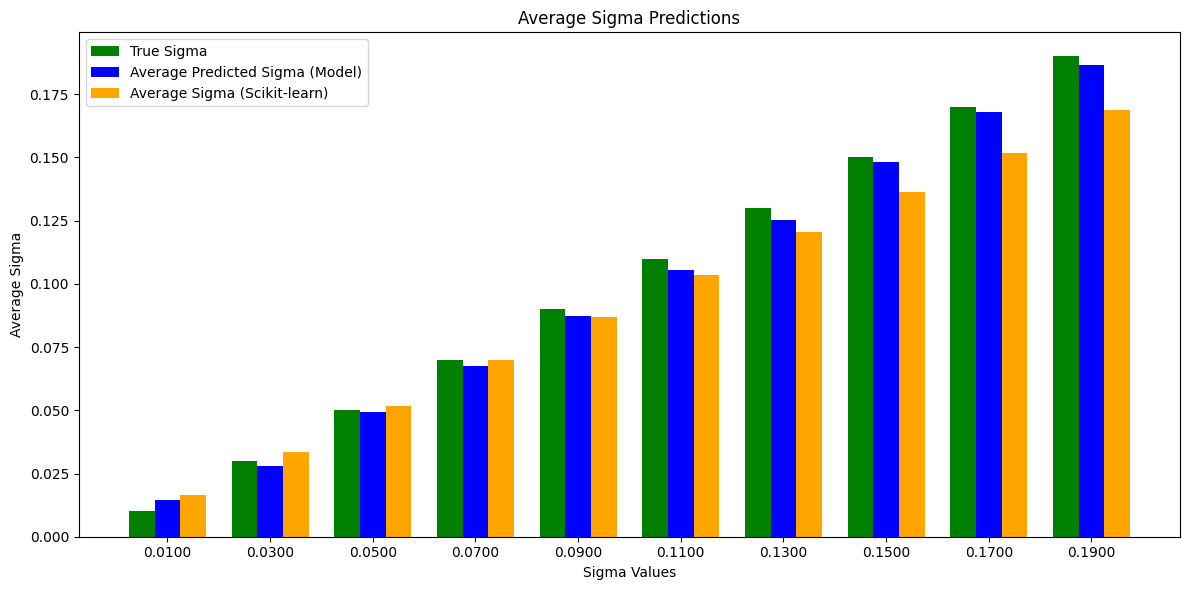

In [18]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

# Define CustomDataset for applying a specific sigma for each image
class CustomDataset2(torch.utils.data.Dataset):
    def __init__(self, image_paths, sigma_values, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.sigma_values = sigma_values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')  # Open image and convert to RGB

        if self.transform:
            image = self.transform(image)  # Apply transformations if provided

        sigma = self.sigma_values[index]  # Assign sigma value based on the image index

        # Add noise directly to the image tensor
        noisy_image = self.add_noise(image, sigma)

        return noisy_image.float(), sigma
        
    def add_noise(self, image, sigma):
        noise = torch.randn_like(image) * sigma
        noisy_image = image + noise 
        noisy_image = torch.clamp(noisy_image, 0, 1)
        return noisy_image

# Evaluate model for each sigma value and calculate averages
def evaluate_sigma(model, transform, sigma_value, images_for_sigma, plotting_dict):
    # Initialize result dictionary
    results_dict = {
        'predicted_sigmas': [],
        'sklearn_sigmas': []
    }

    # Create a dataset for the specific sigma value
    test_dataset = CustomDataset2(image_paths=images_for_sigma, sigma_values=[sigma_value] * len(images_for_sigma), transform=transform)
    testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Loop through the data loader and make predictions
    for i, (noisy_images, sigma) in tqdm(enumerate(testloader), desc=f'Predicting sigmas for {sigma_value:.4f}'):
        noisy_images = noisy_images.to(device)

        # Model prediction
        for noisy_image in noisy_images:
            predicted_sigma = predict_sigma_model(model, noisy_image.unsqueeze(0))  # Assuming it returns float
            results_dict['predicted_sigmas'].append(predicted_sigma)

        # Convert the noisy image to NumPy format for scikit-learn sigma estimation
        noisy_images_np = noisy_images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to (batch, H, W, C)

        # Estimate sigma using scikit-learn for each image in the batch
        sklearn_sigmas = [estimate_sigma_sklearn(image_np) for image_np in noisy_images_np]
        results_dict['sklearn_sigmas'].extend(sklearn_sigmas)

    # Calculate and display the average predicted sigma and sklearn sigma
    if results_dict['predicted_sigmas']:
        avg_predicted_sigma = np.mean(results_dict['predicted_sigmas'])
        avg_sklearn_sigma = np.mean(results_dict['sklearn_sigmas'])

        # Store averages and true sigma value for plotting
        plotting_dict['avg_predicted_sigmas'].append(avg_predicted_sigma)
        plotting_dict['avg_sklearn_sigmas'].append(avg_sklearn_sigma)
        plotting_dict['true_sigmas'].append(sigma_value)  # Store the true sigma value

        print(f"True Sigma: {sigma_value:.4f}")
        print(f"Average Predicted Sigma (Model): {avg_predicted_sigma:.4f}")
        print(f"Average Sigma (Scikit-learn): {avg_sklearn_sigma:.4f}")
        print(f"Difference from True Sigma and Predicted sigma: {abs(avg_predicted_sigma - sigma_value):.4f}")
        print(f"Difference from True Sigma and Scikit-learn sigma: {abs(avg_sklearn_sigma - sigma_value):.4f}")
        print("=" * 50)
    else:
        print(f"Sigma: {sigma_value:.2f} - No Predictions Made")
        print("=" * 50)

# Main evaluation code
image_dir = 'D:/Dr. Jarez Miah_Don\'t delete/Noise estimation/Div2k_Flickr2k_OST/graph/image_1000' 
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('jpg', 'png', 'jpeg'))]
sigmas = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]
images_per_sigma = np.array_split(images, 10)

# Initialize plotting dictionary
plotting_dict = {
    'avg_predicted_sigmas': [],
    'avg_sklearn_sigmas': [],
    'true_sigmas': []
}

# Loop through each sigma value and corresponding 100 images
for sigma_value, images_for_sigma in zip(sigmas, images_per_sigma):
    evaluate_sigma(model, transform, sigma_value, images_for_sigma, plotting_dict)

# Plotting the average values for predicted, sklearn sigmas, and true sigmas
plt.figure(figsize=(12, 6))
x = np.arange(len(sigmas))  # The label locations
width = 0.25  # width of the bars

# Create bars for predicted, sklearn average sigmas, and true sigmas
bars1 = plt.bar(x - width, plotting_dict['true_sigmas'], width, label='True Sigma', color='green')
bars2 = plt.bar(x, plotting_dict['avg_predicted_sigmas'], width, label='Average Predicted Sigma (Model)', color='blue')
bars3 = plt.bar(x + width, plotting_dict['avg_sklearn_sigmas'], width, label='Average Sigma (Scikit-learn)', color='orange')

# Adding labels and title
plt.xlabel('Sigma Values')
plt.ylabel('Average Sigma')
plt.title('Average Sigma Predictions')
plt.xticks(x, [f'{sigma:.4f}' for sigma in sigmas])
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


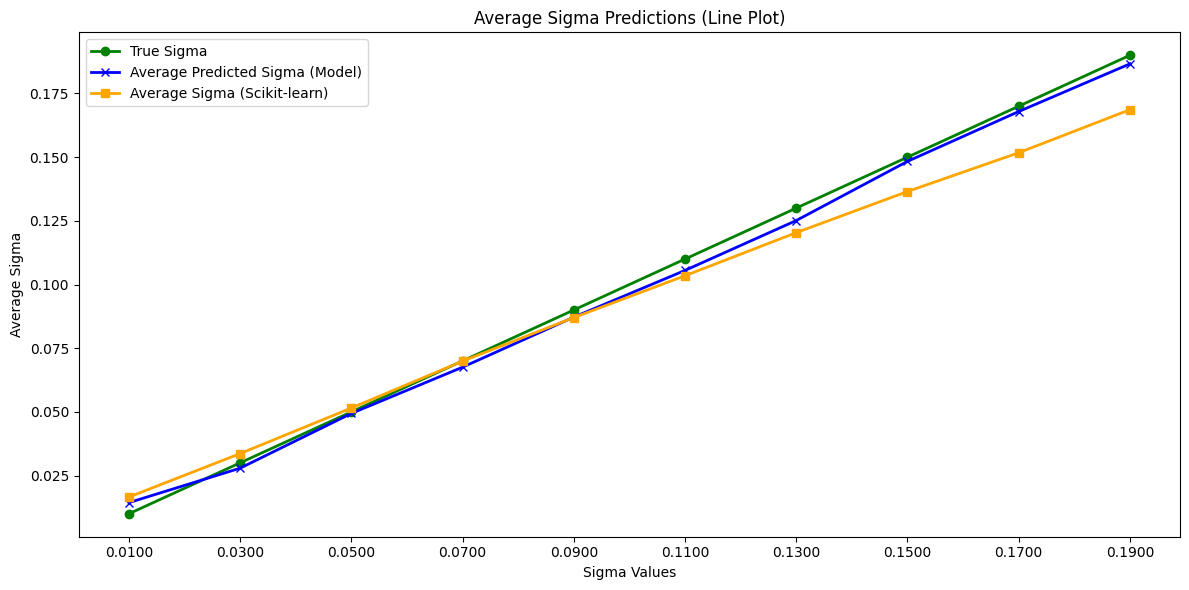

In [20]:
plt.figure(figsize=(12, 6))

# Plot lines for predicted, sklearn average sigmas, and true sigmas
plt.plot(x, plotting_dict['true_sigmas'], color='green', label='True Sigma', marker='o', linewidth=2)
plt.plot(x, plotting_dict['avg_predicted_sigmas'], color='blue', label='Average Predicted Sigma (Model)', marker='x', linewidth=2)
plt.plot(x, plotting_dict['avg_sklearn_sigmas'], color='orange', label='Average Sigma (Scikit-learn)', marker='s', linewidth=2)

# Adding labels and title
plt.xlabel('Sigma Values')
plt.ylabel('Average Sigma')
plt.title('Average Sigma Predictions (Line Plot)')
plt.xticks(x, [f'{sigma:.4f}' for sigma in sigmas])
plt.legend()
'''
# Adding value labels next to each point
for i in range(len(x)):
    plt.text(x[i], plotting_dict['true_sigmas'][i], f'{plotting_dict["true_sigmas"][i]:.4f}', ha='right', va='bottom', color='green')
    plt.text(x[i], plotting_dict['avg_predicted_sigmas'][i], f'{plotting_dict["avg_predicted_sigmas"][i]:.4f}', ha='left', va='bottom', color='blue')
    plt.text(x[i], plotting_dict['avg_sklearn_sigmas'][i], f'{plotting_dict["avg_sklearn_sigmas"][i]:.4f}', ha='right', va='bottom', color='orange')
'''
# Display the plot
plt.tight_layout()
plt.show()


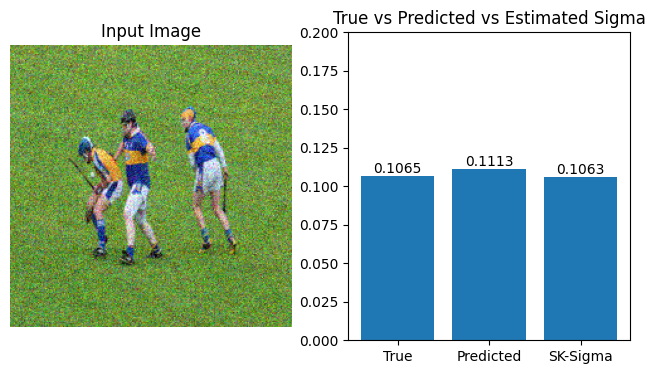

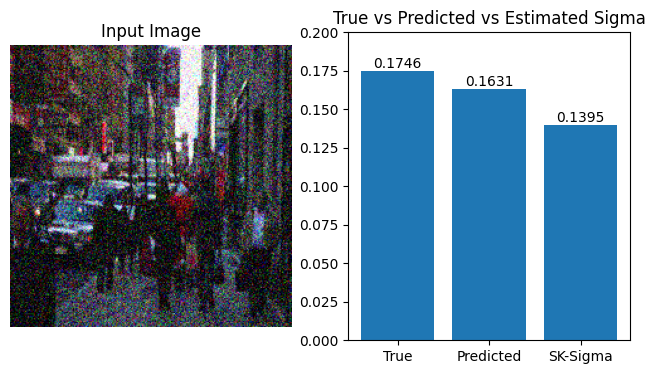

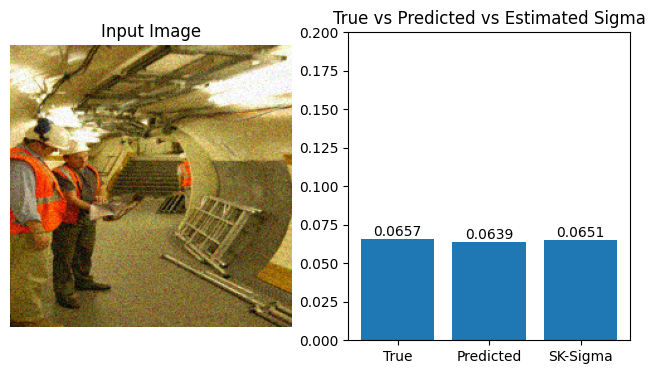

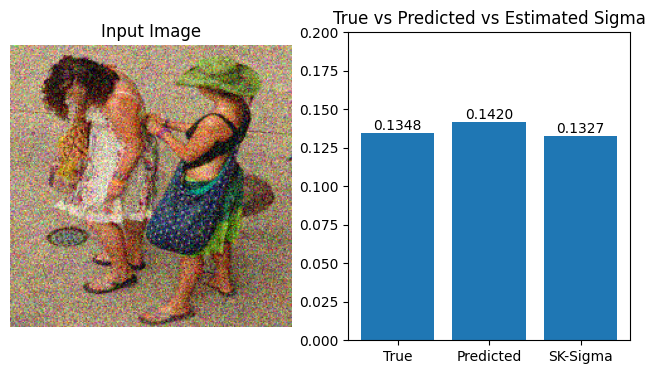

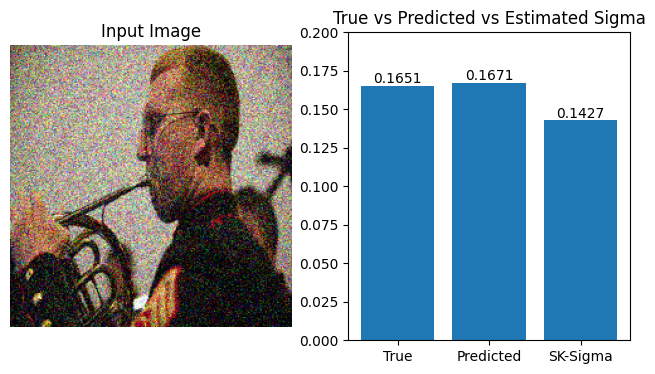

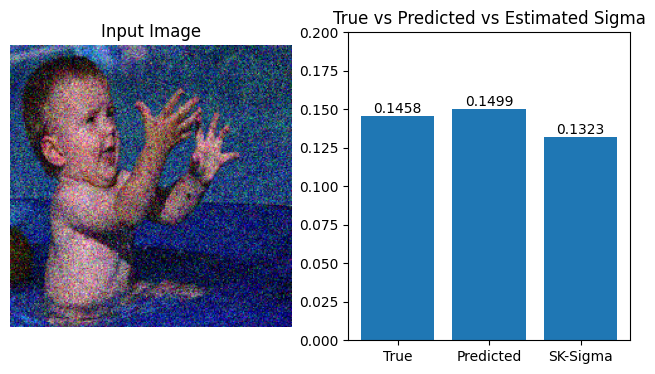

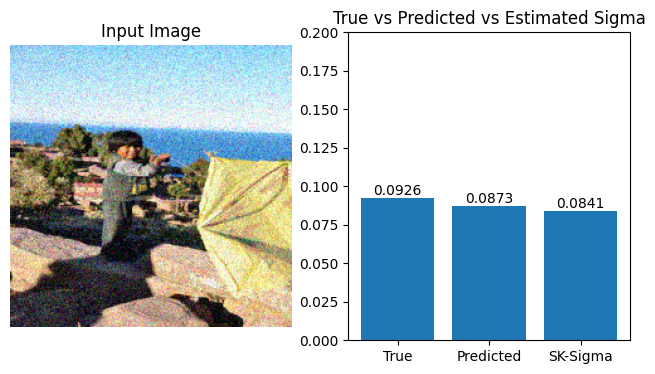

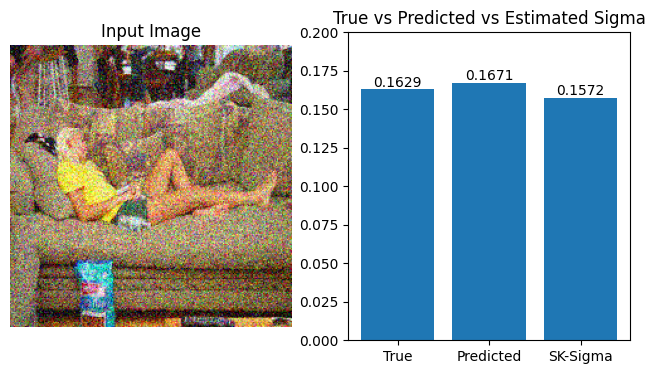

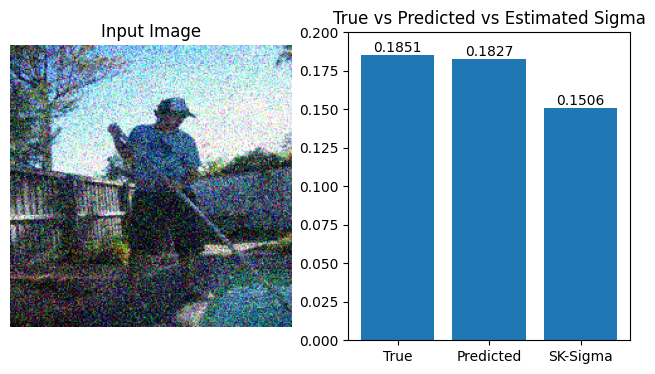

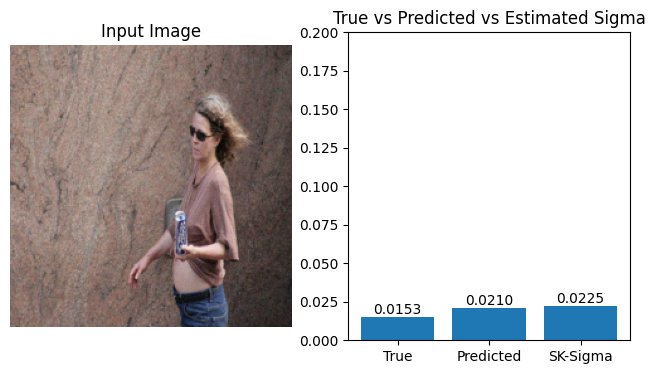

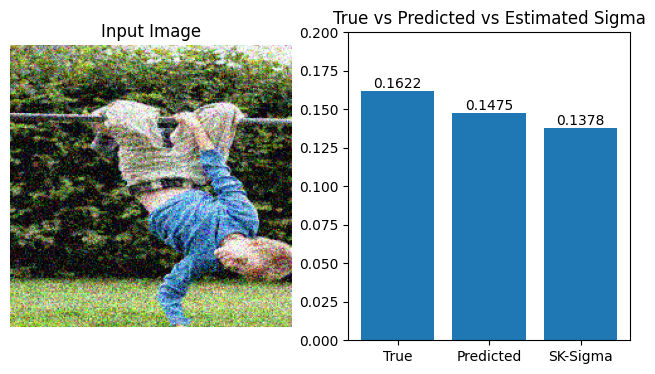

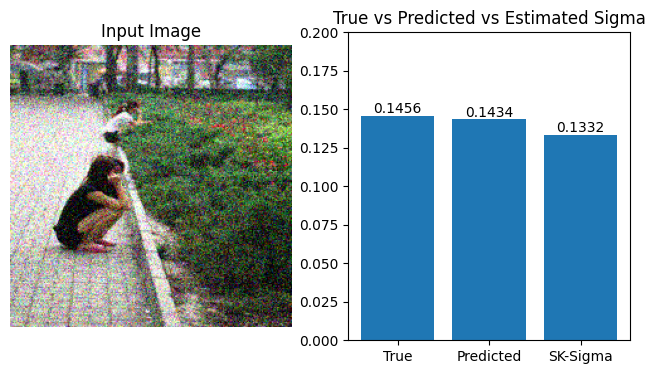

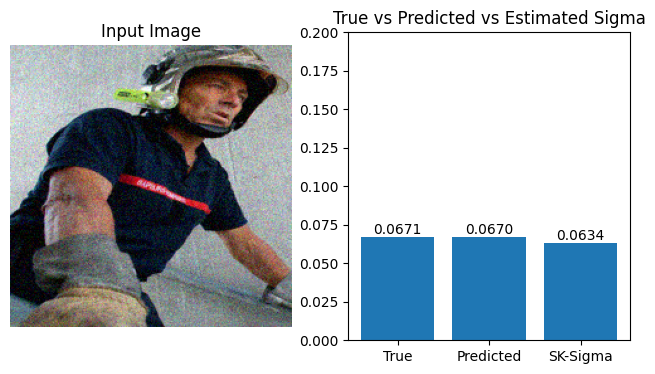

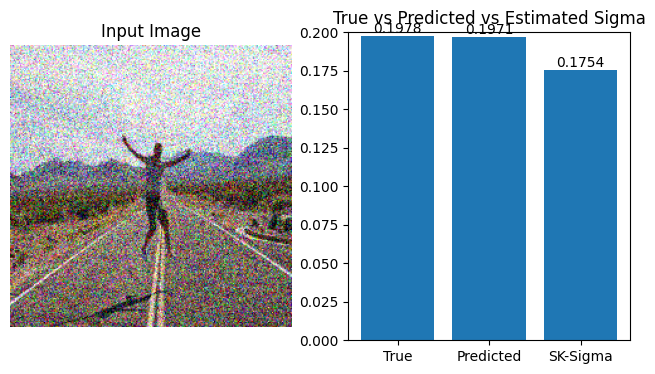

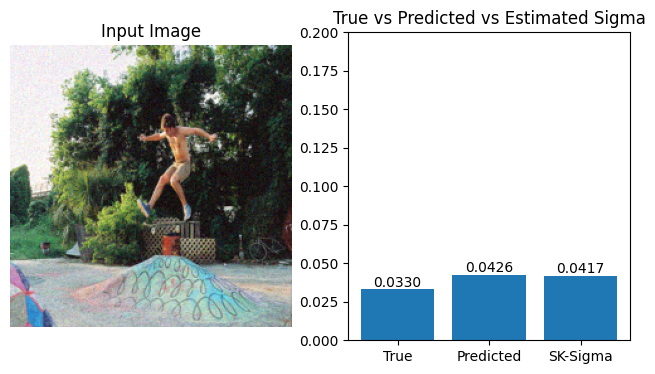

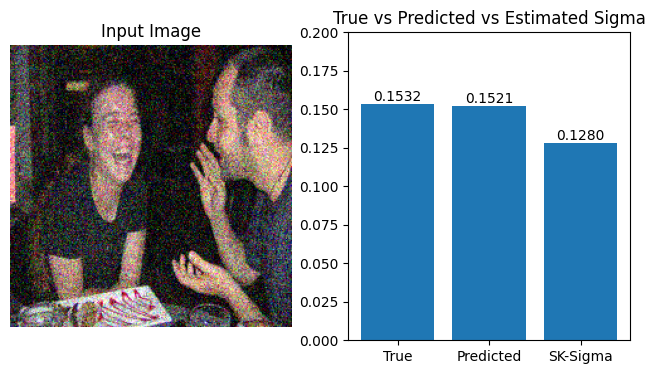

In [22]:
import os
from PIL import Image


def visualize_predictions(model, dataloader, device, save_dir="D:/Dr. Jarez Miah_Don\'t delete/Noise estimation/output/proposed model"):
    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device).float()
            output = model(data)

            # Visualize the predictions
            for i in range(len(data)):
                # Get the input image and move to CPU for processing
                image = data[i].cpu().permute(1, 2, 0).numpy()

                # Estimate sigma using the provided function
                estimated_sigma = estimate_sigma_sklearn(image)

                # Plot input image
                plt.figure(figsize=(8, 4))  # Set figure size for better clarity
                plt.subplot(1, 2, 1)
                plt.imshow(image)
                plt.title('Input Image')
                plt.axis('off')

                # Save the noisy input image to the folder
                image_path = os.path.join(save_dir, f"noisy_image_{batch_idx}_{i}.png")
                pil_image = Image.fromarray((image * 255).astype('uint8'))  # Convert numpy array to PIL Image
                pil_image.save(image_path)

                # Prepare values for bar plot
                true_sigma = target[i].item()
                predicted_sigma = output[i].item()
                sigma_values = [true_sigma, predicted_sigma, estimated_sigma]

                # Plot true, predicted, and estimated sigma
                plt.subplot(1, 2, 2)
                bars = plt.bar(['True', 'Predicted', 'SK-Sigma'], sigma_values)
                plt.title("True vs Predicted vs Estimated Sigma")
                plt.ylim(0, .2)

                # Add value labels on top of each bar
                for bar, value in zip(bars, sigma_values):
                    yval = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{value:.4f}', ha='center', va='bottom')

                plt.show()

            break  # Visualize one batch and stop

# Call the function to visualize predictions and save images
visualize_predictions(model, valloader, device)


In [5]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]         295,040
             ReLU-14          [-1, 128,

========= Analysis of Additive White Gaussian Noise ============

Total images: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


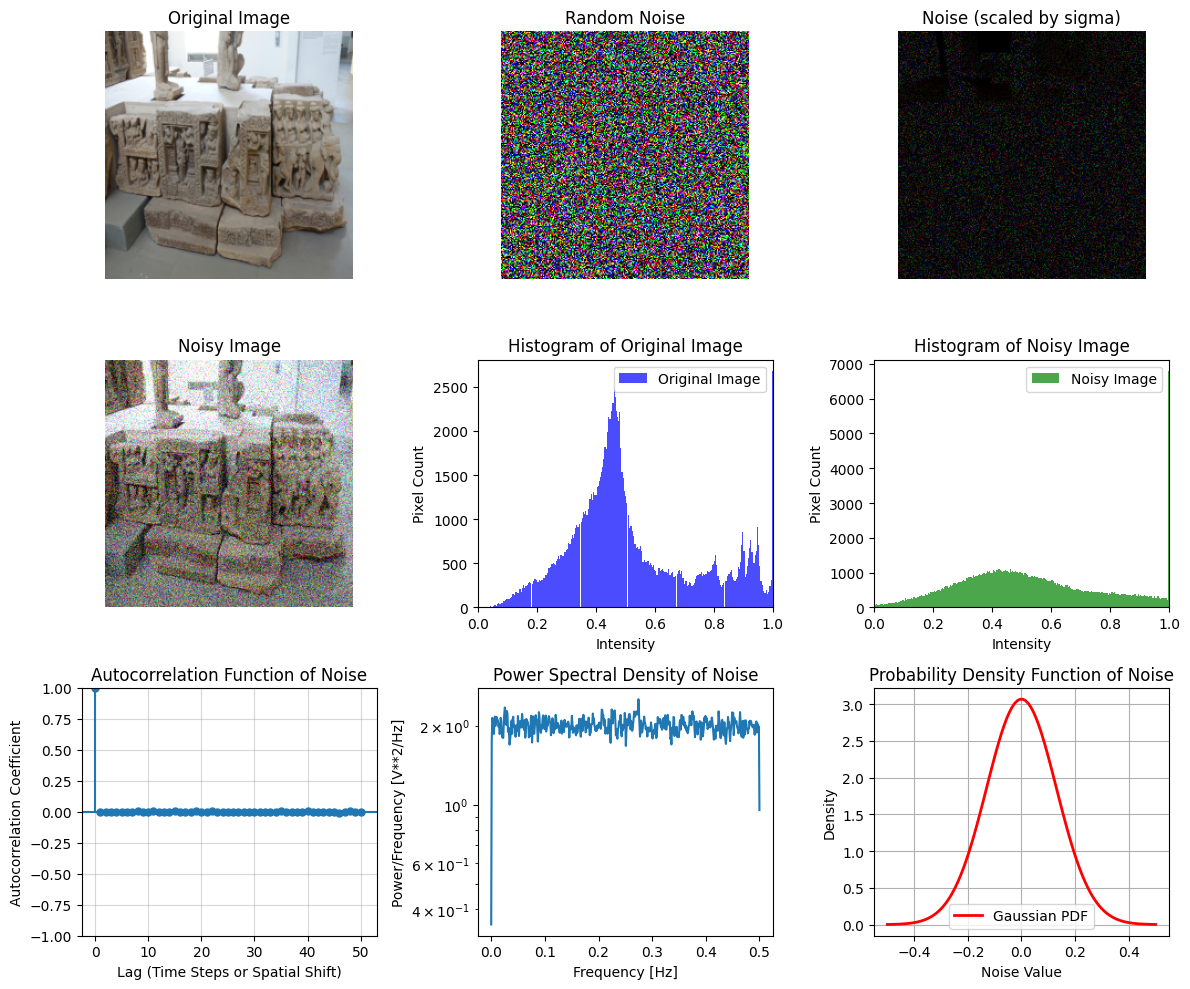

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import welch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Function to add Gaussian noise
def add_noise(image_np, sigma):
    random_noise = np.random.randn(*image_np.shape)
    noisy_image = image_np + random_noise * sigma
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image.astype(np.float32), random_noise, noisy_image - image_np  # Return noisy image and noise

# Custom dataset class
class CustomDataset1(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image) 
    
        image_np = image.permute(1, 2, 0).numpy()  # Convert tensor to a NumPy array

        sigma = 0.13  # Random sigma value

        # Add noise to the image and get the noise
        noisy_image_np, random_noise, noise = add_noise(image_np, sigma)

        return image_np, noisy_image_np, random_noise, noise, sigma

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL images to tensors
]) 

# Load image paths
image_dir = 'D:/Dr. Jarez Miah_Don\'t delete/Noise estimation/Div2k_Flickr2k_OST/graph/image_50/0816.png'
images = [image_dir]
print(f"Total images: {len(images)}")

# Create the dataset and dataloader
test_dataset = CustomDataset1(image_paths=images, transform=transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example: Iterate through the DataLoader and display the images and graphs
for original_image_np, noisy_image_np, random_noise, noise, sigma in testloader:
    original_image_np = original_image_np.squeeze()  # Remove batch dimension
    noisy_image_np = noisy_image_np.squeeze()
    random_noise = random_noise.squeeze()
    noise = noise.squeeze()

    # Set up the plots (adjusted for 3x3 grid)
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    
    # Display original image
    axes[0, 0].imshow(original_image_np)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Display random noise (before scaling by sigma)
    axes[0, 1].imshow(np.clip(random_noise, -1, 1))  # Display random noise (no scaling)
    axes[0, 1].set_title('Random Noise')
    axes[0, 1].axis('off')

    # Display random noise (after scaling by sigma)
    axes[0, 2].imshow(np.clip(noise, -1, 1))  # Display random noise (no scaling)
    axes[0, 2].set_title('Noise (scaled by sigma)')
    axes[0, 2].axis('off')

    # Display noisy image
    axes[1, 0].imshow(noisy_image_np)
    axes[1, 0].set_title('Noisy Image')
    axes[1, 0].axis('off')

    # Plot histograms inside the subplot
    axes[1, 1].hist(original_image_np.ravel(), bins=256, color='blue', alpha=0.7, label='Original Image')
    axes[1, 1].set_title('Histogram of Original Image')
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_xlabel('Intensity')  # x-axis label
    axes[1, 1].set_ylabel('Pixel Count')  # y-axis label
    axes[1, 1].legend()

    # Plot histogram for noisy image inside the subplot
    axes[1, 2].hist(noisy_image_np.ravel(), bins=256, color='green', alpha=0.7, label='Noisy Image')
    axes[1, 2].set_title('Histogram of Noisy Image')
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_xlabel('Intensity')  # x-axis label
    axes[1, 2].set_ylabel('Pixel Count')  # y-axis label
    axes[1, 2].legend()

    # Plot the autocorrelation function of the noise
    plot_acf(random_noise.flatten(), lags=50, ax=axes[2, 0])  # Use random_noise here
    axes[2, 0].set_title('Autocorrelation Function of Noise')
    axes[2, 0].set_xlabel('Lag (Time Steps or Spatial Shift)')
    axes[2, 0].set_ylabel('Autocorrelation Coefficient')
    axes[2, 0].grid(alpha=0.5)

    # Plot the Power Spectral Density (PSD) of the noise
    f, Pxx = welch(random_noise.flatten(), nperseg=1024)  # Use random_noise here
    axes[2, 1].semilogy(f, Pxx)
    axes[2, 1].set_title('Power Spectral Density of Noise')
    axes[2, 1].set_xlabel('Frequency [Hz]')
    axes[2, 1].set_ylabel('Power/Frequency [V**2/Hz]')

    # Calculate and plot the Probability Density Function (PDF) of Gaussian noise
    x = np.linspace(-0.5, 0.5, 100)
    pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x / sigma) ** 2)
    axes[2, 2].plot(x, pdf, color='red', lw=2, label='Gaussian PDF')
    axes[2, 2].set_title('Probability Density Function of Noise')
    axes[2, 2].set_xlabel('Noise Value')
    axes[2, 2].set_ylabel('Density')
    axes[2, 2].legend()
    axes[2, 2].grid()

    # Show all images and graphs
    plt.tight_layout()
    plt.show()


In [19]:
for original_image_np, noisy_image_np, random_noise, noise, sigma in testloader:
    # Squeeze to remove batch dimension
    original_image_np = original_image_np.squeeze()
    noisy_image_np = noisy_image_np.squeeze()
    noise = noise.squeeze()
    random_noise = random_noise.squeeze()

    # Print original, noise, and noisy image values
    print("Original Image Pixel Values (first 10 pixels):")
    print(original_image_np.flatten()[:10])  # Print first 10 pixel values for illustration

    print("\nrandom Noise Values (first 10 pixels):")
    print(random_noise.flatten()[:10])  # Print first 10 noise values

    print("\nNoise Values (first 10 pixels):")
    print(noise.flatten()[:10])  # Print first 10 noise values

    print("\nNoisy Image Pixel Values (first 10 pixels):")
    print(noisy_image_np.flatten()[:10])  # Print first 10 noisy pixel values
    print(sigma)

    break  # Only print for the first batch, then exit


Original Image Pixel Values (first 10 pixels):
tensor([0.4353, 0.3765, 0.3137, 0.4000, 0.3373, 0.2706, 0.4118, 0.3529, 0.2863,
        0.2902])

random Noise Values (first 10 pixels):
tensor([ 0.7460, -1.2910, -2.2095, -0.5507,  0.8656,  0.2962,  0.6328, -0.9026,
         0.3056,  0.4581], dtype=torch.float64)

Noise Values (first 10 pixels):
tensor([ 0.0970, -0.1678, -0.2872, -0.0716,  0.1125,  0.0385,  0.0823, -0.1173,
         0.0397,  0.0596], dtype=torch.float64)

Noisy Image Pixel Values (first 10 pixels):
tensor([0.5323, 0.2086, 0.0265, 0.3284, 0.4498, 0.3091, 0.4940, 0.2356, 0.3260,
        0.3497])
tensor([0.1300], dtype=torch.float64)


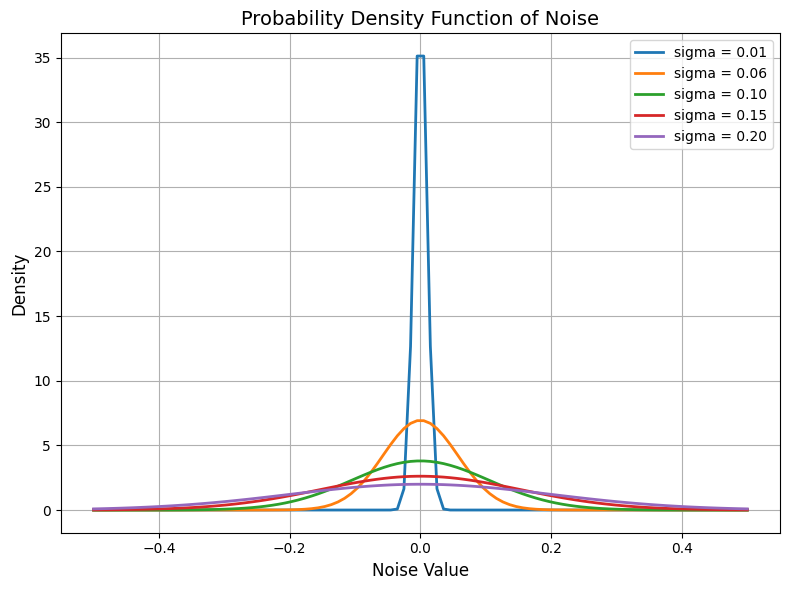

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set up sigma values (10 equally spaced values from 0.01 to 0.20)
sigma_values = np.linspace(0.01, 0.20, 5)

# Create a figure and axes
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# Set up the range for the noise values
x = np.linspace(-0.5, 0.5, 100)

# Plot PDFs for each sigma value
for sigma in sigma_values:
    # Gaussian PDF formula
    pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x / sigma) ** 2)
    axes.plot(x, pdf, label=f'sigma = {sigma:.2f}', lw=2)  # Plot PDF for the current sigma

# Set plot title and labels
axes.set_title('Probability Density Function of Noise', fontsize=14)
axes.set_xlabel('Noise Value', fontsize=12)
axes.set_ylabel('Density', fontsize=12)

# Show legend
axes.legend()

# Add grid for better visibility
axes.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


Total images: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


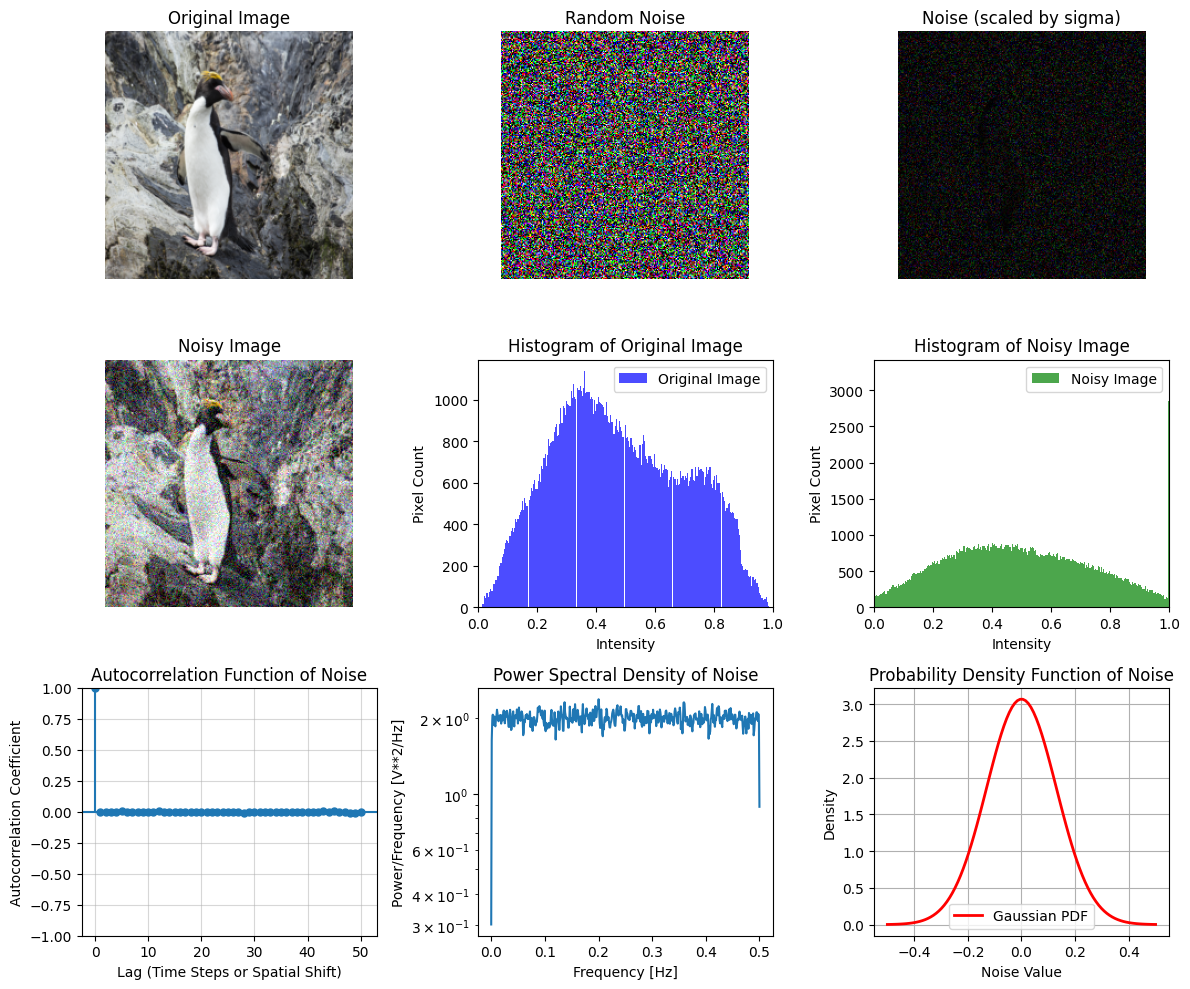

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import welch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Function to add Gaussian noise
def add_noise(image_np, sigma):
    random_noise = np.random.randn(*image_np.shape)
    noisy_image = image_np + random_noise * sigma
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image.astype(np.float32), random_noise, noisy_image - image_np  # Return noisy image and noise

# Custom dataset class
class CustomDataset1(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image) 
    
        image_np = image.permute(1, 2, 0).numpy()  # Convert tensor to a NumPy array

        sigma = 0.13  # Random sigma value

        # Add noise to the image and get the noise
        noisy_image_np, random_noise, noise = add_noise(image_np, sigma)

        return image_np, noisy_image_np, random_noise, noise, sigma

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL images to tensors
]) 

# Load image paths
image_dir ='D:/Dr. Jarez Miah_Don\'t delete/Noise estimation/Div2k_Flickr2k_OST/graph/image_50/0801.png'
images = [image_dir]
print(f"Total images: {len(images)}")

# Create the dataset and dataloader
test_dataset = CustomDataset1(image_paths=images, transform=transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example: Iterate through the DataLoader and display the images and graphs
for original_image_np, noisy_image_np, random_noise, noise, sigma in testloader:
    original_image_np = original_image_np.squeeze()  # Remove batch dimension
    noisy_image_np = noisy_image_np.squeeze()
    random_noise = random_noise.squeeze()
    noise = noise.squeeze()

    # Set up the plots (adjusted for 3x3 grid)
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    
    # Display original image
    axes[0, 0].imshow(original_image_np)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Display random noise (before scaling by sigma)
    axes[0, 1].imshow(np.clip(random_noise, -1, 1))  # Display random noise (no scaling)
    axes[0, 1].set_title('Random Noise')
    axes[0, 1].axis('off')

    # Display random noise (after scaling by sigma)
    axes[0, 2].imshow(np.clip(noise, -1, 1))  # Display random noise (no scaling)
    axes[0, 2].set_title('Noise (scaled by sigma)')
    axes[0, 2].axis('off')

    # Display noisy image
    axes[1, 0].imshow(noisy_image_np)
    axes[1, 0].set_title('Noisy Image')
    axes[1, 0].axis('off')

    # Plot histograms inside the subplot
    axes[1, 1].hist(original_image_np.ravel(), bins=256, color='blue', alpha=0.7, label='Original Image')
    axes[1, 1].set_title('Histogram of Original Image')
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_xlabel('Intensity')  # x-axis label
    axes[1, 1].set_ylabel('Pixel Count')  # y-axis label
    axes[1, 1].legend()

    # Plot histogram for noisy image inside the subplot
    axes[1, 2].hist(noisy_image_np.ravel(), bins=256, color='green', alpha=0.7, label='Noisy Image')
    axes[1, 2].set_title('Histogram of Noisy Image')
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_xlabel('Intensity')  # x-axis label
    axes[1, 2].set_ylabel('Pixel Count')  # y-axis label
    axes[1, 2].legend()

    # Plot the autocorrelation function of the noise
    plot_acf(random_noise.flatten(), lags=50, ax=axes[2, 0])  # Use random_noise here
    axes[2, 0].set_title('Autocorrelation Function of Noise')
    axes[2, 0].set_xlabel('Lag (Time Steps or Spatial Shift)')
    axes[2, 0].set_ylabel('Autocorrelation Coefficient')
    axes[2, 0].grid(alpha=0.5)

    # Plot the Power Spectral Density (PSD) of the noise
    f, Pxx = welch(random_noise.flatten(), nperseg=1024)  # Use random_noise here
    axes[2, 1].semilogy(f, Pxx)
    axes[2, 1].set_title('Power Spectral Density of Noise')
    axes[2, 1].set_xlabel('Frequency [Hz]')
    axes[2, 1].set_ylabel('Power/Frequency [V**2/Hz]')

    # Calculate and plot the Probability Density Function (PDF) of Gaussian noise
    x = np.linspace(-0.5, 0.5, 100)
    pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (x / sigma) ** 2)
    axes[2, 2].plot(x, pdf, color='red', lw=2, label='Gaussian PDF')
    axes[2, 2].set_title('Probability Density Function of Noise')
    axes[2, 2].set_xlabel('Noise Value')
    axes[2, 2].set_ylabel('Density')
    axes[2, 2].legend()
    axes[2, 2].grid()

    # Show all images and graphs
    plt.tight_layout()
    plt.show()
